In [38]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import re
from random import randint, seed
from IPython.display import display
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Import du dataset

In [39]:
path = 'maladie_cardiaque.csv'
maladie = pd.read_csv(path,sep=',',header=0, index_col=1)
maladie = maladie.drop(columns=['Unnamed: 0'])
maladie.head(5)
 

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade
id,,,,,,,,,,,,
0,18393,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non
1,20228,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui
2,18857,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui
3,17623,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui
4,17474,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non


# Analyse superficielle du dataset

In [40]:
from data_analyzer import analyse

resultat = analyse(maladie)
display(resultat)

(70000, 12)

,Name,dtypes,Missing,Miss_Percent,Unique,First Value,Second Value,Third Value
0,age,int64,0,0.0,8076,18393,20228,18857
1,genre,object,0,0.0,2,homme,femme,femme
2,taille,int64,0,0.0,109,168,156,165
3,Poids,float64,0,0.0,287,62.0,85.0,64.0
4,pression_systo,int64,0,0.0,153,110,140,130
5,pression_diasto,int64,0,0.0,157,80,90,70
6,cholesterol,object,0,0.0,3,normal,tres eleve,tres eleve
7,glycemie,int64,0,0.0,3,1,1,1
8,fumeur,object,0,0.0,2,non fumeur,non fumeur,non fumeur
9,conso_alco,object,0,0.0,2,non,non,non


In [41]:
maladie.describe()

,age,taille,Poids,pression_systo,pression_diasto,glycemie,activite_physique
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414,1.226457,0.803729
std,2467.251667,8.210126,14.395757,154.011419,188.472530,0.572270,0.397179
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,0.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,1.000000


In [42]:
#Class construite pour étudier et analyser l'architecture de notre dataset
class sr_value:
    def __init__(self,data):
        self.dt=data
        
    #Valeurs prises par chaque feature     
    def pos_value(self):
        for i in self.dt.columns:
            print(f'* la colonne {i} a comme valeur possible{self.dt[i].unique()}')
            print('\n')
            
    #distribution des valeurs ordinal feature 
    def ct_ord_value(self,ord_val):
        for i in ord_val:
            print(f' La variable ordinale {i} a comme distibution de ces valeurs le schéma suivant :\n {self.dt[i].value_counts()}')
            print('\n')
        
    #Nombre de valeur pour chaque attribut
    def ct_value(self):
        for i in self.dt.columns:
            print(f'* La colonne {i} a comme valeurs possibles : {len(self.dt[i].unique())}')
            print('\n')

In [43]:
data_architecture=sr_value(maladie)
#Regardons le nombre de valeurs prises de nos features
data_architecture.ct_value()

* La colonne age a comme valeurs possibles : 8076


* La colonne genre a comme valeurs possibles : 2


* La colonne taille a comme valeurs possibles : 109


* La colonne Poids a comme valeurs possibles : 287


* La colonne pression_systo a comme valeurs possibles : 153


* La colonne pression_diasto a comme valeurs possibles : 157


* La colonne cholesterol a comme valeurs possibles : 3


* La colonne glycemie a comme valeurs possibles : 3


* La colonne fumeur a comme valeurs possibles : 2


* La colonne conso_alco a comme valeurs possibles : 2


* La colonne activite_physique a comme valeurs possibles : 2


* La colonne malade a comme valeurs possibles : 2




# Data Prep

Création d'une colonne pour avoir l'âge en année

In [44]:
maladie["Age (années)"] = maladie["age"]/365

Ajout d'une colonne avec l'IMC des individus

In [45]:
maladie["IMC"] = maladie['Poids']/((maladie['taille']/100)*(maladie['taille']/100))
maladie

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,Age (années),IMC
id,,,,,,,,,,,,,,
0,18393,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non,50.391781,21.967120
1,20228,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui,55.419178,34.927679
2,18857,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui,51.663014,23.507805
3,17623,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui,48.282192,28.710479
4,17474,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non,47.873973,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,homme,168,76.0,120,80,normal,1,fumeur,non,1,non,52.712329,26.927438
99995,22601,femme,158,126.0,140,90,eleve,2,non fumeur,non,1,oui,61.920548,50.472681
99996,19066,homme,183,105.0,180,90,tres eleve,1,non fumeur,oui,0,oui,52.235616,31.353579


Binarisation des données

In [46]:
maladie['genre_binaire'] = maladie['genre'].map({'homme': 0, 'femme': 1})
maladie['conso_alco_binaire'] = maladie['conso_alco'].map({'non': 0, 'oui': 1})
maladie['fumeur_binaire'] = maladie['fumeur'].map({'non fumeur': 0, 'fumeur': 1})
maladie['malade_binaire'] = maladie['malade'].map({'non': 0, 'oui': 1})

Caractérisation de l'IMC

In [47]:
maladie.drop_duplicates(inplace=True)
labels = ['Sous-poids', 'Normal', 'Surpoids', 'Obèse']
maladie['IMC_Categorie'] = pd.cut(maladie['IMC'], bins=[0, 18.5, 25, 30, float('inf')], labels=labels, include_lowest=True)


Séparation des individus en tranche d'âge

In [48]:
bins = [0, 18, 35, 50, 70, float('inf')]
labels = ['0-18', '19-35', '36-50', '51-70', '70+']
maladie['Age_Categorie'] = pd.cut(maladie['Age (années)'], bins=bins, labels=labels, include_lowest=True)

In [49]:
maladie['Ratio_Poids_Taille'] = maladie['Poids'] / (maladie['taille'] / 100)

In [50]:
conditions = [
    (maladie['pression_systo'] < 120) & (maladie['pression_diasto'] < 80),
    (maladie['pression_systo'] >= 120) & (maladie['pression_systo'] < 130) & (maladie['pression_diasto'] < 80),
    (maladie['pression_systo'] >= 130) | (maladie['pression_diasto'] >= 80)
]
labels = ['Normale', 'Hypertension Légère', 'Hypertension']
maladie['Pression_Arterielle_Categorie'] = np.select(conditions, labels, default='Inconnu')

In [51]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,...,Age (années),IMC,genre_binaire,conso_alco_binaire,fumeur_binaire,malade_binaire,IMC_Categorie,Age_Categorie,Ratio_Poids_Taille,Pression_Arterielle_Categorie
id,,,,,,,,,,,,,,,,,,,,,
0,18393,homme,168,62.0,110,80,normal,1,non fumeur,non,...,50.391781,21.967120,0,0,0,0,Normal,51-70,36.904762,Hypertension
1,20228,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,...,55.419178,34.927679,1,0,0,1,Obèse,51-70,54.487179,Hypertension
2,18857,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,...,51.663014,23.507805,1,0,0,1,Normal,51-70,38.787879,Hypertension
3,17623,homme,169,82.0,150,100,normal,1,non fumeur,non,...,48.282192,28.710479,0,0,0,1,Surpoids,36-50,48.520710,Hypertension
4,17474,femme,156,56.0,100,60,normal,1,non fumeur,non,...,47.873973,23.011177,1,0,0,0,Normal,36-50,35.897436,Normale


Détéctions des outliners

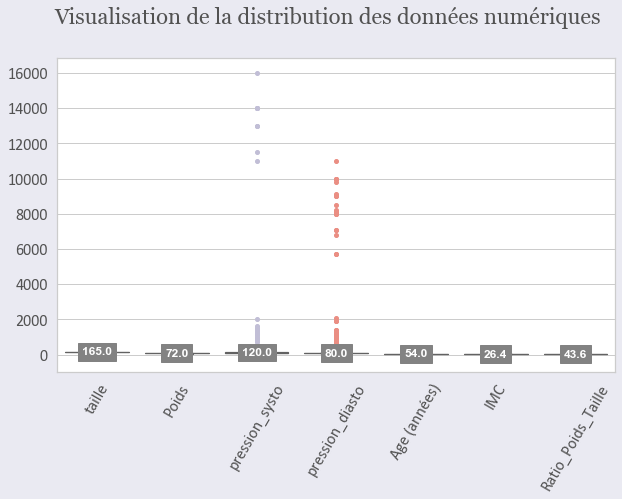

In [52]:
# Boxplot des outliners

var_num = ['taille', 'Poids', 'pression_systo', 'pression_diasto', "Age (années)", 'IMC', "Ratio_Poids_Taille"]
maladie[var_num] = maladie[var_num].apply(pd.to_numeric, errors='coerce', axis=1)

sns.set(style='whitegrid')
facecolor = '#eaeaf2'
fig, ax = plt.subplots(figsize=(10, 6), facecolor=facecolor)

x = sns.boxplot(data=maladie,
                       palette='Set3',
                       linewidth=1.2,
                       fliersize=2,
                       order=['taille', 'Poids', 'pression_systo', 'pression_diasto', "Age (années)",'IMC', "Ratio_Poids_Taille"],
                       flierprops=dict(marker='o', markersize=4))

font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=16, color=font_color, **hfont)

title = 'Visualisation de la distribution des données numériques'
fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
plt.subplots_adjust(top=0.85)

for i, box in enumerate(ax.artists):
         col = box.get_facecolor()
         plt.setp(ax.lines[i*6+5], mfc=col, mec=col)

lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1)
    ax.text(
        cat,
        y,
        f'{y}',
        ha='center',
        va='center',
        fontweight='semibold',
        size=12,
        color='white',
        bbox=dict(facecolor='#828282', edgecolor='#828282')
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.show()

In [53]:
maladie["IMC"].mean()

27.557610036546464

Suppression des outliners

In [54]:
out_filter = ((maladie["pression_systo"]>250) | (maladie["pression_diasto"]>200))
maladie = maladie[~out_filter]
out_filter2 = ((maladie["pression_systo"] < 0) | (maladie["pression_diasto"] < 0))
maladie = maladie[~out_filter2]
out_filter3 = ((maladie["taille"] > 200))
maladie = maladie[~out_filter3]
out_filter4 = ((maladie["IMC"] > 200))
maladie = maladie[~out_filter4]

In [55]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,...,Age (années),IMC,genre_binaire,conso_alco_binaire,fumeur_binaire,malade_binaire,IMC_Categorie,Age_Categorie,Ratio_Poids_Taille,Pression_Arterielle_Categorie
id,,,,,,,,,,,,,,,,,,,,,
0,18393,homme,168.0,62.0,110.0,80.0,normal,1,non fumeur,non,...,50.391781,21.967120,0,0,0,0,Normal,51-70,36.904762,Hypertension
1,20228,femme,156.0,85.0,140.0,90.0,tres eleve,1,non fumeur,non,...,55.419178,34.927679,1,0,0,1,Obèse,51-70,54.487179,Hypertension
2,18857,femme,165.0,64.0,130.0,70.0,tres eleve,1,non fumeur,non,...,51.663014,23.507805,1,0,0,1,Normal,51-70,38.787879,Hypertension
3,17623,homme,169.0,82.0,150.0,100.0,normal,1,non fumeur,non,...,48.282192,28.710479,0,0,0,1,Surpoids,36-50,48.520710,Hypertension
4,17474,femme,156.0,56.0,100.0,60.0,normal,1,non fumeur,non,...,47.873973,23.011177,1,0,0,0,Normal,36-50,35.897436,Normale


# DataViz

Distribution des maladies cardiaques ou non

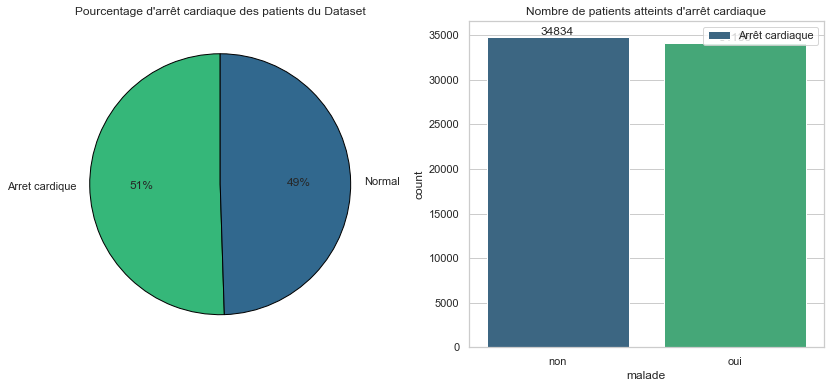

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(14, 6))

colors = sns.color_palette("viridis", len(maladie['malade'].value_counts()))

# Inverser l'ordre des couleurs
colors = colors[::-1]

# Diagramme circulaire
ax1.pie(maladie['malade'].value_counts(), labels=["Arret cardique", "Normal"], autopct="%1.0f%%", startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
ax1.set(title="Pourcentage d'arrêt cardiaque des patients du Dataset")

# Diagramme en barres
sns.countplot(x='malade', data=maladie, ax=ax2, palette="viridis")
for i, j in enumerate(maladie['malade'].value_counts().values):
    ax2.text(i, j, str(j), ha='center', va='bottom', fontsize=12)
ax2.set(title="Nombre de patients atteints d'arrêt cardiaque")
ax2.legend(labels=["Arrêt cardiaque", "Normal"])


# Affichage
plt.show()


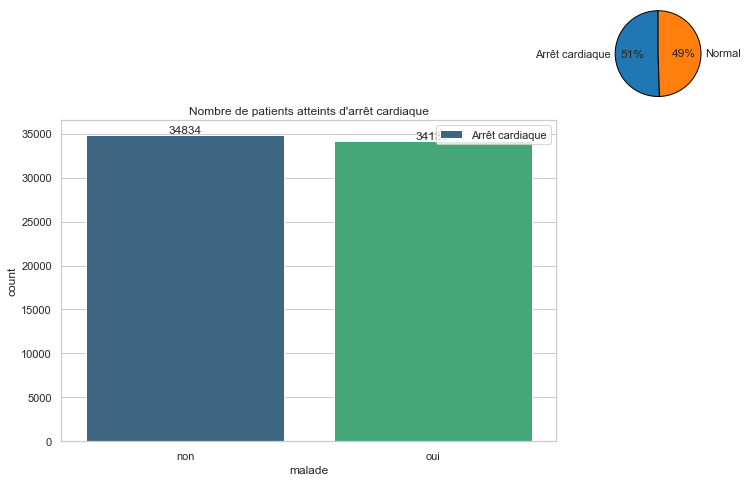

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Création de la figure et des sous-graphiques
plt.figure(figsize=(12, 8))
gs = plt.GridSpec(4, 4)

# Tracé du graphique principal (histogramme)
ax2 = plt.subplot(gs[1:, :-1])
sns.countplot(x='malade', data=maladie, ax=ax2, palette="viridis")
for i, j in enumerate(maladie['malade'].value_counts().values):
    ax2.text(i, j, str(j), ha='center', va='bottom', fontsize=12)
ax2.set(title="Nombre de patients atteints d'arrêt cardiaque")
ax2.legend(labels=["Arrêt cardiaque", "Normal"])

# Tracé du diagramme circulaire (en petit)
ax1 = plt.subplot(gs[0, -1])
colors = ['#1f77b4', '#ff7f0e']  # Couleurs pour le diagramme circulaire
ax1.pie(maladie['malade'].value_counts(), labels=["Arrêt cardiaque", "Normal"], autopct="%1.0f%%", startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})

# Réglage de l'apparence du deuxième graphique
ax1.axis('equal')  # Pour que le diagramme circulaire soit parfaitement circulaire
plt.show()


Distribution de l'âge

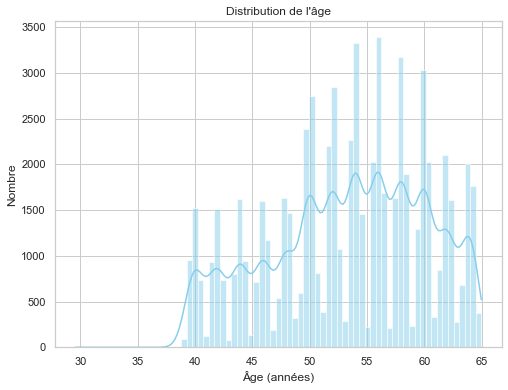

In [58]:
plt.figure(figsize=(8, 6))  # Ajustement de la taille de la figure

# Création du subplot avec seaborn
ax = plt.subplot(111)  # Utilisation d'un seul subplot pour ce tracé
sns.histplot(maladie['Age (années)'], ax=ax, kde=True, color='skyblue')  # Ajout d'un kernel density estimate (KDE) pour une meilleure visualisation de la distribution
plt.title("Distribution de l'âge")  # Ajout d'un titre descriptif

# Ajout de labels pour les axes
plt.xlabel("Âge (années)")
plt.ylabel("Nombre")

# Ajout de la grille pour une meilleure lisibilité
plt.grid(True)

plt.show()

Répartition par genre

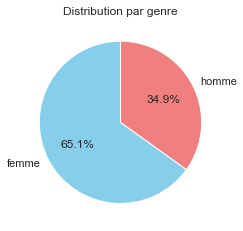

In [59]:
plt.figure(figsize=(8, 6))  # Ajustement de la taille de la figure

# Création du subplot
plt.subplot(121)  # Utilisation d'un seul subplot pour ce tracé
plt.title("Distribution par genre")  # Ajout d'un titre descriptif

# Création du diagramme circulaire avec des couleurs personnalisées
colors = ['skyblue', 'lightcoral', 'lightgreen']
plt.pie(maladie['genre'].value_counts(), labels=maladie['genre'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)

plt.show()


In [60]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,...,Age (années),IMC,genre_binaire,conso_alco_binaire,fumeur_binaire,malade_binaire,IMC_Categorie,Age_Categorie,Ratio_Poids_Taille,Pression_Arterielle_Categorie
id,,,,,,,,,,,,,,,,,,,,,
0,18393,homme,168.0,62.0,110.0,80.0,normal,1,non fumeur,non,...,50.391781,21.967120,0,0,0,0,Normal,51-70,36.904762,Hypertension
1,20228,femme,156.0,85.0,140.0,90.0,tres eleve,1,non fumeur,non,...,55.419178,34.927679,1,0,0,1,Obèse,51-70,54.487179,Hypertension
2,18857,femme,165.0,64.0,130.0,70.0,tres eleve,1,non fumeur,non,...,51.663014,23.507805,1,0,0,1,Normal,51-70,38.787879,Hypertension
3,17623,homme,169.0,82.0,150.0,100.0,normal,1,non fumeur,non,...,48.282192,28.710479,0,0,0,1,Surpoids,36-50,48.520710,Hypertension
4,17474,femme,156.0,56.0,100.0,60.0,normal,1,non fumeur,non,...,47.873973,23.011177,1,0,0,0,Normal,36-50,35.897436,Normale


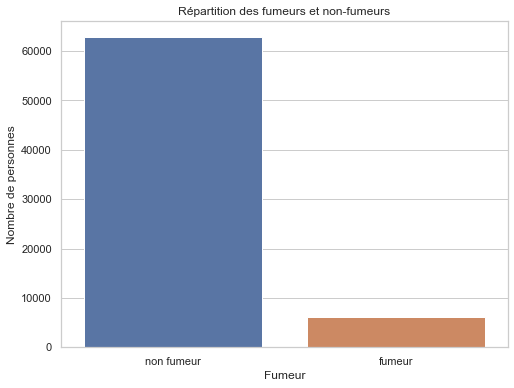

In [61]:
# Diagramme en barres de fumeurs et non-fumeurs
plt.figure(figsize=(8, 6))
sns.countplot(x='fumeur', data=maladie)
plt.title('Répartition des fumeurs et non-fumeurs')
plt.xlabel('Fumeur')
plt.ylabel('Nombre de personnes')
plt.show()

# Variables d'intérêt

RFE

In [62]:
#linmodel = LinearRegression()
#rfe1 = RFE(estimator=linmodel,n_features_to_select=7,step=1,verbose=3)
#rfe1.fit(x_train,y_train)
#
#var_sel = rfe1.get_support()
#
#plt.matshow(var_sel.reshape(1,-1), cmap = 'gray_r')
#plt.xlabel('Feature selection')
#plt.yticks([]);

# Modèle IA

KNN

In [63]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,...,Age (années),IMC,genre_binaire,conso_alco_binaire,fumeur_binaire,malade_binaire,IMC_Categorie,Age_Categorie,Ratio_Poids_Taille,Pression_Arterielle_Categorie
id,,,,,,,,,,,,,,,,,,,,,
0,18393,homme,168.0,62.0,110.0,80.0,normal,1,non fumeur,non,...,50.391781,21.967120,0,0,0,0,Normal,51-70,36.904762,Hypertension
1,20228,femme,156.0,85.0,140.0,90.0,tres eleve,1,non fumeur,non,...,55.419178,34.927679,1,0,0,1,Obèse,51-70,54.487179,Hypertension
2,18857,femme,165.0,64.0,130.0,70.0,tres eleve,1,non fumeur,non,...,51.663014,23.507805,1,0,0,1,Normal,51-70,38.787879,Hypertension
3,17623,homme,169.0,82.0,150.0,100.0,normal,1,non fumeur,non,...,48.282192,28.710479,0,0,0,1,Surpoids,36-50,48.520710,Hypertension
4,17474,femme,156.0,56.0,100.0,60.0,normal,1,non fumeur,non,...,47.873973,23.011177,1,0,0,0,Normal,36-50,35.897436,Normale


In [64]:
data_col = maladie[['Age (années)','taille','Poids','pression_systo','pression_diasto','glycemie','activite_physique','fumeur_binaire','conso_alco_binaire','malade_binaire','genre_binaire']]
data_col.head()

,Age (années),taille,Poids,pression_systo,pression_diasto,glycemie,activite_physique,fumeur_binaire,conso_alco_binaire,malade_binaire,genre_binaire
id,,,,,,,,,,,
0,50.391781,168.0,62.0,110.0,80.0,1,1,0,0,0,0
1,55.419178,156.0,85.0,140.0,90.0,1,1,0,0,1,1
2,51.663014,165.0,64.0,130.0,70.0,1,0,0,0,1,1
3,48.282192,169.0,82.0,150.0,100.0,1,1,0,0,1,0
4,47.873973,156.0,56.0,100.0,60.0,1,0,0,0,0,1


In [65]:
target = data_col['malade_binaire']
data = data_col.drop(['malade_binaire'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(data, target, random_state = 0, test_size = 0.2)

In [66]:
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [67]:
math.sqrt(len(y_test))

117.44786077234443

In [68]:
param_grid = {
    'n_neighbors': [60, 80, 120],  # ajustez cette plage selon vos besoins
    'p': [1, 2],  # Norme de distance (1 pour la distance de Manhattan, 2 pour la distance euclidienne)
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Créer un classifieur KNN
knn = KNeighborsClassifier()

# Effectuer une recherche par validation croisée
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [69]:
grid_search.fit(x_train[:5000], y_train[:5000])
#grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [60, 80, 120], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [70]:
# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleurs estimateurs:", grid_search.best_estimator_)

Meilleurs paramètres: {'algorithm': 'auto', 'n_neighbors': 80, 'p': 1, 'weights': 'distance'}
Meilleurs estimateurs: KNeighborsClassifier(n_neighbors=80, p=1, weights='distance')


In [71]:
# Entraîner le modèle avec les meilleurs paramètres
best_knn = grid_search.best_estimator_
best_knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=80, p=1, weights='distance')

In [72]:
# Prédire les étiquettes de test
y_train_pred = best_knn.predict(x_train)
y_test_pred = best_knn.predict(x_test)

In [73]:
# Calculer le R^2 sur les données d'entraînement et de test
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Calculer la racine carrée de l'erreur quadratique moyenne (RMSE) sur les données d'entraînement et de test
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Afficher les résultats
print("R^2 sur le set d'entraînement:", r2_train)
print("R^2 sur le set de test:", r2_test)
print("RMSE sur le set d'entraînement:", rmse_train)
print("RMSE sur le set de test:", rmse_test)

R^2 sur le set d'entraînement: 0.9992749673352253
R^2 sur le set de test: -0.12674790960666749
RMSE sur le set d'entraînement: 0.013462596491928507
RMSE sur le set de test: 0.5307016046022913


In [74]:
# Calculer la précision
accuracy = accuracy_score(y_test, y_test_pred)
print("Précision du modèle avec les meilleurs paramètres:", accuracy)
accuracy = accuracy_score(y_train, y_train_pred)
print("Précision du modèle avec les meilleurs paramètres:", accuracy)

Précision du modèle avec les meilleurs paramètres: 0.7183558068725533
Précision du modèle avec les meilleurs paramètres: 0.9998187584956955


In [75]:
cm = confusion_matrix(y_test,y_test_pred)
cm2 = confusion_matrix(y_train,y_train_pred)

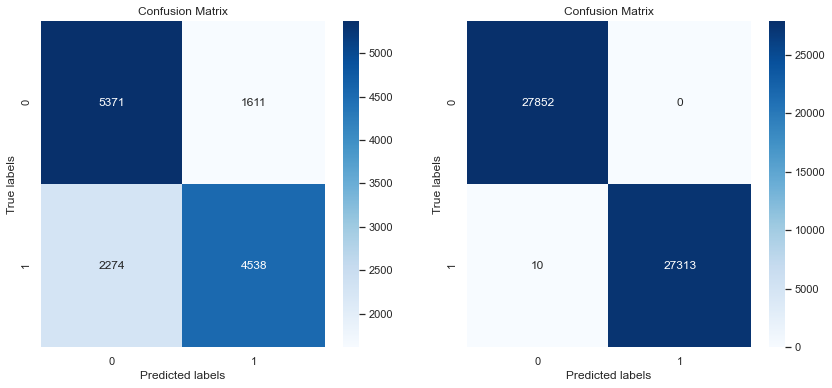

In [76]:
# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(14, 6))
plt.subplot(121)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.subplot(122)
sns.heatmap(cm2, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

On cherche à déterminer si le patient est réellement malade. Ce qui importe ici, c'est de savoir s'il est effectivement malade et non pas s'il ne l'est pas.